In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import pickle


In [2]:
data = pd.read_csv(r"C:\Users\ACER\OneDrive\Desktop\Unifiedmentor\vehicle_price_prediction\Vehicle_Price_Prediction\dataset.csv")


In [3]:
print(data.head())
print(" ")
print(" ")
print(data.info())
print(" ")
print(" ")
print(data.describe())
print(" ")
print(" ")
print(data.isnull().sum())


                              name  \
0     2024 Jeep Wagoneer Series II   
1  2024 Jeep Grand Cherokee Laredo   
2         2024 GMC Yukon XL Denali   
3       2023 Dodge Durango Pursuit   
4            2024 RAM 3500 Laramie   

                                         description   make           model  \
0  \n      \n        Heated Leather Seats, Nav Sy...   Jeep        Wagoneer   
1  Al West is committed to offering every custome...   Jeep  Grand Cherokee   
2                                                NaN    GMC        Yukon XL   
3  White Knuckle Clearcoat 2023 Dodge Durango Pur...  Dodge         Durango   
4  \n      \n        2024 Ram 3500 Laramie Billet...    RAM            3500   

   year    price                                             engine  \
0  2024  74600.0                            24V GDI DOHC Twin Turbo   
1  2024  50170.0                                                OHV   
2  2024  96410.0  6.2L V-8 gasoline direct injection, variable v...   
3  2023  468

In [4]:
# 2. Handle Missing Values and Data Cleaning
print("Initial missing values:\n", data.isnull().sum())

data = data.dropna(subset=['price'])
data = data.dropna(subset=['mileage'])

# Group infrequent categories (optional)
make_counts = data['make'].value_counts()
infrequent_makes = make_counts[make_counts < 50].index
data['make'] = data['make'].replace(infrequent_makes, 'Other')

model_counts = data['model'].value_counts()
infrequent_models = model_counts[model_counts < 50].index
data['model'] = data['model'].replace(infrequent_models, 'Other')

# Handle missing 'cylinders'
data['cylinders'].fillna(data['cylinders'].median(), inplace=True)  # Impute with median

for col in ['transmission', 'fuel', 'body', 'exterior_color', 'interior_color', 'drivetrain']:
    data[col].fillna(data[col].mode()[0], inplace=True)

print("\nMissing values after imputation:\n", data.isnull().sum())

Initial missing values:
 name                0
description        56
make                0
model               0
year                0
price              23
engine              2
cylinders         105
fuel                7
mileage            34
transmission        2
trim                1
body                3
doors               7
exterior_color      5
interior_color     38
drivetrain          0
dtype: int64

Missing values after imputation:
 name               0
description       55
make               0
model              0
year               0
price              0
engine             2
cylinders          0
fuel               0
mileage            0
transmission       0
trim               1
body               0
doors              7
exterior_color     0
interior_color     0
drivetrain         0
dtype: int64


C:\Users\ACER\AppData\Local\Temp\ipykernel_9120\53509080.py:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['cylinders'].fillna(data['cylinders'].median(), inplace=True)  # Impute with median
C:\Users\ACER\AppData\Local\Temp\ipykernel_9120\53509080.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

In [5]:
data

,name,description,make,model,year,price,engine,cylinders,fuel,mileage,transmission,trim,body,doors,exterior_color,interior_color,drivetrain
0,2024 Jeep Wagoneer Series II,"\n \n Heated Leather Seats, Nav Sy...",Jeep,Other,2024,74600.0,24V GDI DOHC Twin Turbo,6.0,Gasoline,10.0,8-Speed Automatic,Series II,SUV,4.0,White,Global Black,Four-wheel Drive
1,2024 Jeep Grand Cherokee Laredo,Al West is committed to offering every custome...,Jeep,Other,2024,50170.0,OHV,6.0,Gasoline,1.0,8-Speed Automatic,Laredo,SUV,4.0,Metallic,Global Black,Four-wheel Drive
2,2024 GMC Yukon XL Denali,NaN,Other,Other,2024,96410.0,"6.2L V-8 gasoline direct injection, variable v...",8.0,Gasoline,0.0,Automatic,Denali,SUV,4.0,Summit White,Teak/Light Shale,Four-wheel Drive
3,2023 Dodge Durango Pursuit,White Knuckle Clearcoat 2023 Dodge Durango Pur...,Dodge,Other,2023,46835.0,16V MPFI OHV,8.0,Gasoline,32.0,8-Speed Automatic,Pursuit,SUV,4.0,White Knuckle Clearcoat,Black,All-wheel Drive
4,2024 RAM 3500 Laramie,\n \n 2024 Ram 3500 Laramie Billet...,RAM,3500,2024,81663.0,24V DDI OHV Turbo Diesel,6.0,Diesel,10.0,6-Speed Automatic,Laramie,Pickup Truck,4.0,Silver,Black,Four-wheel Drive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
997,2024 Mercedes-Benz Sprinter 2500 Standard Roof,2024 Mercedes-Benz Sprinter 2500 Cargo 144 WB ...,Other,Other,2024,59037.0,16V DDI DOHC Turbo Diesel,4.0,Diesel,10.0,9-Speed Automatic,Standard Roof,Cargo Van,3.0,Arctic White,Black,Rear-wheel Drive
998,2024 Dodge Hornet Hornet R/T Plus Eawd,Dealer Comments +++ Price Ends 5/31/2024 +++ A...,Dodge,Hornet,2024,49720.0,"4 gasoline direct injection, DOHC, Multiair va...",4.0,Gasoline,0.0,6-Spd Aisin F21-250 PHEV Auto Trans,Hornet R/T Plus Eawd,SUV,4.0,Acapulco Gold,Black,All-wheel Drive
999,2024 Jeep Wagoneer Base,\n \n The ALL New Friendship CDJR ...,Jeep,Other,2024,69085.0,24V GDI DOHC Twin Turbo,6.0,Gasoline,20.0,8-Speed Automatic,Base,SUV,4.0,Diamond Black,Black,Four-wheel Drive
1000,2024 Nissan Murano SV Intelligent AWD,"\n \n CVT with Xtronic, AWD.At Tod...",Other,Other,2024,43495.0,"6 DOHC, variable valve control, regular unlead...",6.0,Gasoline,6.0,Automatic,SV Intelligent AWD,SUV,4.0,Pearl White Tricoat,Graphite,All-wheel Drive


In [6]:
# 3. Feature Engineering
current_year = 2025
data['age'] = current_year - data['year']
data['price'] = np.log1p(data['price'])

data = data.drop(['name', 'description', 'trim', 'engine', 'doors'], axis=1,errors='ignore')



In [7]:

# 4. Data Preprocessing
numerical_features = ['year', 'mileage', 'age', 'cylinders']
categorical_features = ['fuel', 'transmission', 'body', 'exterior_color', 'interior_color', 'drivetrain', 'make', 'model'] 

# Create transformers
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # crucial for handling new categories in the test set
])

# Create preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='drop'
    )


In [8]:
# 5. Data Splitting
X = data.drop('price', axis=1)
y = data['price']


In [9]:
print("NaN values in X before splitting:\n", X.isnull().sum())


NaN values in X before splitting:
 make              0
model             0
year              0
cylinders         0
fuel              0
mileage           0
transmission      0
body              0
exterior_color    0
interior_color    0
drivetrain        0
age               0
dtype: int64


In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [11]:
# Define the model
model= RandomForestRegressor(n_estimators=100, random_state=42)

In [12]:
# Create a pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),('model', model)])

In [13]:
# Train the model
pipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['year', 'mileage', 'age',
                                                   'cylinders']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['fuel', 'transmission',
                                                   'body', 'exterior_color',
                                                   'interior_color',
                                                   'drivetrain', 'make',
                                                   'model'])])),
                ('model', RandomForestRegressor(random_state=42))])

In [14]:
# 7. Model Evaluation
y_pred = pipeline.predict(X_test)

In [15]:
X_test.columns

Index(['make', 'model', 'year', 'cylinders', 'fuel', 'mileage', 'transmission',
       'body', 'exterior_color', 'interior_color', 'drivetrain', 'age'],
      dtype='object')

In [16]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Mean Squared Error: 0.02524552643345379
R-squared: 0.7922197639245788


In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

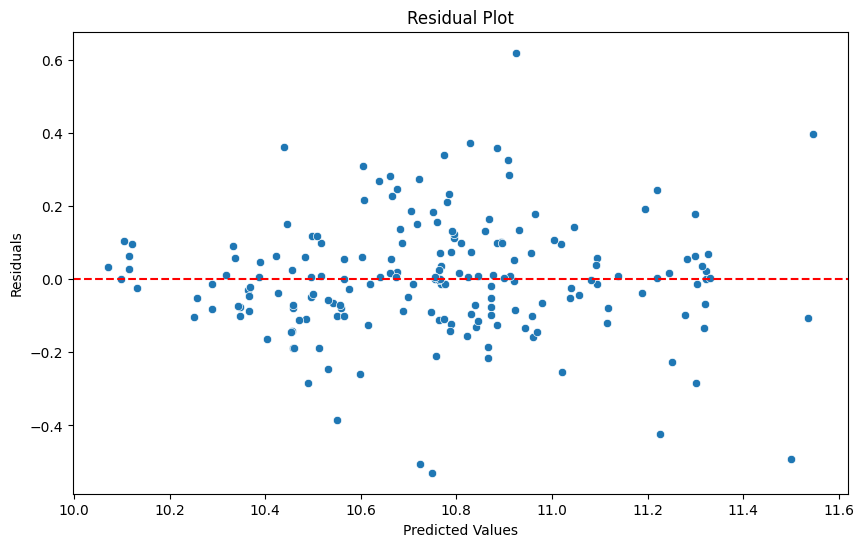

In [18]:
#Residual plot
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()


In [19]:
# 8. Model Persistence (Saving the Model)
filename = 'vehicle_price_model.pkl'
pickle.dump(pipeline, open(filename, 'wb'))

print(f"Model saved to {filename}")


Model saved to vehicle_price_model.pkl


In [20]:
# 9. Prediction for New Vehicle Specifications
def predict_price(make, model, year, cylinders, fuel, mileage, transmission, body, exterior_color, interior_color, drivetrain, age):
    
    # Create a DataFrame from the input specifications
    new_vehicle = pd.DataFrame({
        'make': [make],
        'model': [model],
        'year': [year],
        'cylinders': [cylinders],
        'fuel': [fuel],
        'mileage': [mileage],
        'transmission': [transmission],
        'body': [body],
        'exterior_color': [exterior_color],
        'interior_color': [interior_color],
        'drivetrain': [drivetrain],
        'age' : [age]
        
    })

    print(new_vehicle.columns)
    print(new_vehicle.head())

    
    # Preprocess the new vehicle data using the same preprocessor
    #new_vehicle_processed = preprocessor.transform(new_vehicle)

    # Ensure correct column names after preprocessing
    #onehot_columns = pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)
    #all_columns = numerical_features + onehot_columns.tolist()
    #new_vehicle_processed = pd.DataFrame(new_vehicle_processed, columns=all_columns)

    # Predict the log-transformed price
    predicted_price_log = pipeline.predict(new_vehicle)

    # Convert back to the original price scale
    #predicted_price = np.expm1(predicted_price_log)

    return predicted_price_log

In [21]:
# Example Usage
make = 'jeep'
model = 'wagoneer'
year = 2024
mileage = 10000
cylinders = 6
fuel = 'Gasoline'
transmission = 'Automatic'
body = 'SUV'
exterior_color = 'Red'
interior_color = 'Black'
drivetrain = 'Four-wheel Drive'
age = 2




In [22]:
predicted_price = predict_price(make, model, year, cylinders, fuel, mileage, transmission, body, exterior_color, interior_color, drivetrain, age)
#print("\nPredicted Price: ${predicted_price:,.2f}")  
print("Predicted Price: ", predicted_price)



Index(['make', 'model', 'year', 'cylinders', 'fuel', 'mileage', 'transmission',
       'body', 'exterior_color', 'interior_color', 'drivetrain', 'age'],
      dtype='object')
   make     model  year  cylinders      fuel  mileage transmission body  \
0  jeep  wagoneer  2024          6  Gasoline    10000    Automatic  SUV   

  exterior_color interior_color        drivetrain  age  
0            Red          Black  Four-wheel Drive    2  
Predicted Price:  [11.15830928]
